In [13]:
# === 1️ Setup & Imports ===
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit


In [14]:
# === 2️ Load processed dataset ===
processed_path = Path("./data/processed/crypto_features.csv")
df = pd.read_csv(processed_path, parse_dates=["Date"]).sort_values(["Name","Date"])
print(" Loaded processed dataset:", df.shape)
print(df.head(3))


 Loaded processed dataset: (8142, 17)
      Name                Date  LogReturn  Volatility_7d  Volatility_30d  \
0  Bitcoin 2013-04-29 23:59:59  -0.003573      -0.471133       -0.518136   
1  Bitcoin 2013-04-30 23:59:59  -0.729296      -0.471133       -0.518136   
2  Bitcoin 2013-05-01 23:59:59  -3.090928       1.453074        1.575664   

   Momentum_7d  Momentum_30d  Close_lag1  Close_lag7  Close_lag30  \
0    -0.032620     -0.068549   -0.039989   -0.043431    -0.077756   
1    -1.836824     -3.170161   -0.323441   -0.043431    -0.077756   
2    -4.813778     -8.306402   -0.324176   -0.043431    -0.077756   

   Volume_lag1  Volume_lag7  Volume_lag30  Bollinger_Width  DayOfWeek  \
0    -0.402534    -0.401335     -0.401902        -0.412876  -1.498926   
1    -0.472872    -0.401335     -0.401902        -0.831533  -0.999079   
2    -0.472872    -0.401335     -0.401902         0.315612  -0.499233   

      Month       Close  
0 -0.730178  144.539993  
1 -0.730178  139.000000  
2 -0.4385

# Step 2 — Baseline model: ARIMA (per-coin)

In [15]:
# === 3️ ARIMA Baseline ===
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import root_mean_squared_error

coins = df["Name"].unique()[:3]
results_arima = []

for coin in coins:
    sub = df[df["Name"]==coin].dropna(subset=["Close"]).set_index("Date")
    train_size = int(len(sub) * 0.8)
    train, test = sub["Close"][:train_size], sub["Close"][train_size:]

    preds, history = [], list(train)
    for t in range(len(test)):
        model = ARIMA(history, order=(1,1,1))
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        preds.append(yhat)
        history.append(test.iloc[t])

    mae = mean_absolute_error(test, preds)
    rmse = root_mean_squared_error(test, preds)
    results_arima.append({"Coin": coin, "Model": "ARIMA", "MAE": mae, "RMSE": rmse})

arima_df = pd.DataFrame(results_arima)
print(" ARIMA complete")
arima_df


 ARIMA complete


,Coin,Model,MAE,RMSE
0,Bitcoin,ARIMA,657.436297,1227.793446
1,Ethereum,ARIMA,51.916483,101.583342
2,Litecoin,ARIMA,4.586320,9.308238


# Step 3 — LightGBM model
-- Predict next-day price using lagged features.

In [7]:
!pip install lightgbm


   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   --------------------- ------------------ 0.8/1.5 MB 11.2 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 10.8 MB/s  0:00:00


In [16]:
# === 4️ LightGBM Regression (Feature-based) ===
import lightgbm as lgb

feature_cols = [
    "LogReturn","Volatility_7d","Volatility_30d","Momentum_7d","Momentum_30d",
    "Close_lag1","Close_lag7","Close_lag30",
    "Volume_lag1","Volume_lag7","Volume_lag30",
    "Bollinger_Width","DayOfWeek","Month"
]
target_col = "Close"

results_lgb = []

for coin in df["Name"].unique()[:3]:
    sub = df[df["Name"]==coin].dropna(subset=feature_cols + [target_col]).reset_index(drop=True)
    X = sub[feature_cols]
    y = sub[target_col]

    tscv = TimeSeriesSplit(n_splits=5)
    rmse_scores, mae_scores = [], []

    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = lgb.LGBMRegressor(
            n_estimators=400,
            learning_rate=0.05,
            num_leaves=31,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42
        )
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        rmse = mean_squared_error(y_test, preds, squared=False)
        mae = mean_absolute_error(y_test, preds)
        rmse_scores.append(rmse)
        mae_scores.append(mae)

    results_lgb.append({
        "Coin": coin,
        "Model": "LightGBM",
        "MAE": np.mean(mae_scores),
        "RMSE": np.mean(rmse_scores)
    })

lgb_df = pd.DataFrame(results_lgb)
print(" LightGBM complete")
lgb_df


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1862
[LightGBM] [Info] Number of data points in the train set: 501, number of used features: 14
[LightGBM] [Info] Start training from score 429.607228
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

,Coin,Model,MAE,RMSE
0,Bitcoin,LightGBM,3619.540404,5399.392176
1,Ethereum,LightGBM,173.931981,276.502017
2,Litecoin,LightGBM,19.538871,27.656608


# Step 4 — LSTM (Deep Learning sequence model)

In [18]:
# === 5️ LSTM Model (Deep Learning) ===
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

results_lstm = []

for coin in df["Name"].unique()[:3]:  # start with Bitcoin
    sub = df[df["Name"]==coin].dropna(subset=["Close"]).copy()
    close_vals = sub["Close"].values.reshape(-1,1)

    scaler = MinMaxScaler(feature_range=(0,1))
    scaled = scaler.fit_transform(close_vals)

    X, y = [], []
    window = 60  # 60 days
    for i in range(window, len(scaled)):
        X.append(scaled[i-window:i, 0])
        y.append(scaled[i, 0])
    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(X.shape[1],1)),
        Dropout(0.2),
        LSTM(64),
        Dropout(0.2),
        Dense(1)
    ])

    model.compile(optimizer="adam", loss="mse")
    history = model.fit(X, y, epochs=15, batch_size=32, verbose=1)

    preds = model.predict(X)
    preds_inv = scaler.inverse_transform(preds)
    y_inv = scaler.inverse_transform(y.reshape(-1,1))

    rmse = np.sqrt(mean_squared_error(y_inv, preds_inv))
    mae = mean_absolute_error(y_inv, preds_inv)
    results_lstm.append({"Coin": coin, "Model": "LSTM", "MAE": mae, "RMSE": rmse})

lstm_df = pd.DataFrame(results_lstm)
print(" LSTM complete")
lstm_df


Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 0.0084
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0010
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 8.9138e-04
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 7.4659e-04
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 6.1424e-04
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 8.9044e-04
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 5.0968e-04
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 8.6313e-04
Epoch 9/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 7.1170e-04
Epoch 10/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 5.5240e-04
Epoch 11/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 6.2668e-04
Epoch 12/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 4.9342e-04
Epoch 13/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 3.9521e-04
Epoch 14/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 7.5087e-04
Epoch 15/15
92/92 ━━━━━

,Coin,Model,MAE,RMSE
0,Bitcoin,LSTM,714.140520,1009.356913
1,Ethereum,LSTM,32.121867,67.078795
2,Litecoin,LSTM,5.547200,8.511748


# Step 5 — Combine results & leaderboard

In [19]:
# === 6️ Combine all model results ===
leaderboard = pd.concat([arima_df, lgb_df, lstm_df], ignore_index=True)
leaderboard = leaderboard.sort_values("RMSE").reset_index(drop=True)
leaderboard.to_csv("../data/processed/leaderboard.csv", index=False)
leaderboard


,Coin,Model,MAE,RMSE
0,Litecoin,LSTM,5.547200,8.511748
1,Litecoin,ARIMA,4.586320,9.308238
2,Litecoin,LightGBM,19.538871,27.656608
3,Ethereum,LSTM,32.121867,67.078795
4,Ethereum,ARIMA,51.916483,101.583342
5,Ethereum,LightGBM,173.931981,276.502017
6,Bitcoin,LSTM,714.140520,1009.356913
7,Bitcoin,ARIMA,657.436297,1227.793446
8,Bitcoin,LightGBM,3619.540404,5399.392176


# Section 7: Visual Comparison (Bar Plot)

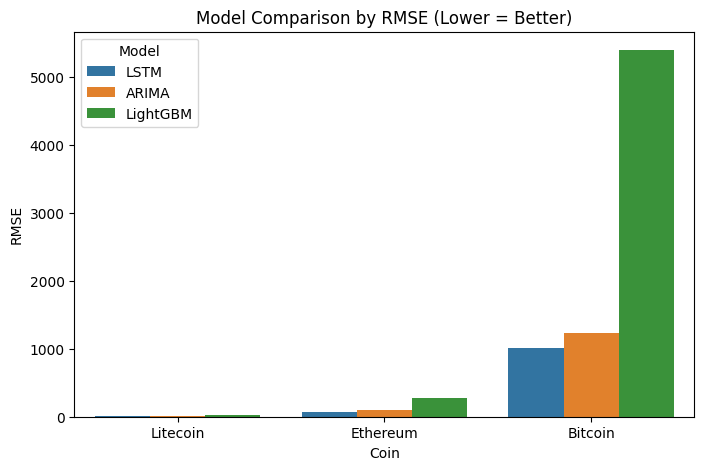

In [20]:
plt.figure(figsize=(8,5))
sns.barplot(data=leaderboard, x="Coin", y="RMSE", hue="Model")
plt.title("Model Comparison by RMSE (Lower = Better)")
plt.ylabel("RMSE")
plt.xlabel("Coin")
plt.legend(title="Model")
plt.show()
